In [1]:
%%capture
# If you're in Colab...
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*

Above installs Category_encoders whcih we will need for this repositroy.


# Predicting Home Prices in Iowa

Building a regression model that can predict the sale price of a house in Aimes, Iowa.

In [2]:
# Imports I will be using
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma.core import mean
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
# Running the data set through a function
def wrangle(filepath):
  # Sets the index of DF to the year a home was sold and sets data as a datetime type
  df = pd.read_csv(filepath, parse_dates=['Yr_Sold'], index_col='Yr_Sold')

  # Creates a new column in DF
  df['Total_Baths'] = (df['Half_Bath'] + df['Bsmt_Full_Bath'] + df['Full_Bath'] +df['Bsmt_Half_Bath']).astype(int)

  # one hot encoding for the columns to one column
  building_type = ['1Fam','TwnhsE','Duplex','Twnhs','2fmCon']
  for b in building_type:
    df[b] = df['Bldg_Type'].str.contains(b).astype(int)

  # Creating binary columns
  df['Central_Air'] = df['Central_Air'].apply(lambda x: 1 if x =="Y" else 0)
  df['Utilities'] = df['Utilities'].apply(lambda x: 1 if x =="AllPub" else 0)
  df['Exter_Cond'] = df['Exter_Cond'].apply(lambda x: 1 if x =="TA" else 0)
  df['Condition_1'] = df['Condition_1'].apply(lambda x: 1 if x =="Norm" else 0)
  df['Condition_2'] = df['Condition_2'].apply(lambda x: 1 if x =="Norm" else 0)

  # dropping baths and other high cardinality categorical columns
  df = df.drop(columns = ['Half_Bath','Bsmt_Full_Bath','Full_Bath','Bsmt_Half_Bath','Bldg_Type','Year_Remod/Add'])

  return df


filepath = 'https://drive.google.com/uc?export=download&id=1tmYLQ1RwIgjI_d66PWnlXU-5D_VxtiQc'

In [4]:
# Runs the data assinged to filepath through the function above
df = wrangle(filepath)

# Display top 5 rows to give a little peak
df.head()


,1st_Flr_SF,Bedroom_AbvGr,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Exterior_1st,Exterior_2nd,...,Street,TotRms_AbvGrd,Utilities,Year_Built,Total_Baths,1Fam,TwnhsE,Duplex,Twnhs,2fmCon
Yr_Sold,,,,,,,,,,,,,,,,,,,,,
2009-01-01,882,2,1,1,1,SBrkr,1,TA,MetalSd,MetalSd,...,Pave,5,1,1956,1,1,0,0,0,0
2009-01-01,1434,4,1,1,1,SBrkr,1,TA,Plywood,Plywood,...,Pave,7,1,1974,3,1,0,0,0,0
2009-01-01,2000,4,1,1,1,SBrkr,1,Gd,Plywood,Wd Sdng,...,Pave,9,1,1972,4,1,0,0,0,0
2009-01-01,945,3,1,1,1,SBrkr,1,TA,VinylSd,VinylSd,...,Pave,7,1,1997,3,1,0,0,0,0
2009-01-01,1008,4,1,1,1,SBrkr,1,Gd,VinylSd,VinylSd,...,Pave,9,1,2003,3,1,0,0,0,0


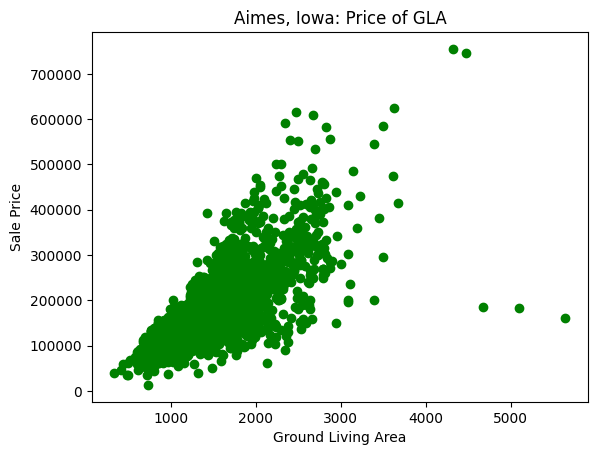

In [5]:
# Visual of plotting sale price to the ground living area
plt.scatter(x= df['Gr_Liv_Area'], y=df['SalePrice'], c='green')

# Labels
plt.xlabel('Ground Living Area')
plt.ylabel('Sale Price')

# Display plot
plt.title('Aimes, Iowa: Price of GLA');


# Split Data

Predicting the price at which a house will be sold.

In [6]:
target = 'SalePrice'

X = df.drop(columns=target)
y = df[target]
X.shape # (2564, 45)
y.shape # (2564,)

(2564,)

# Training and Validation
Splitting `X` and `y` into training and validation sets. Since housing prices fluctuate over time, I will use a time-based cutoff method.

Training: Homes sold before 2009

Validation: Homes sold during 2009

In [7]:
# Set time to divide before and after
cuttoff = '2009'

# Sold before '2009' variable
mask = X.index < cuttoff

# Training
X_train, y_train = X.loc[mask], y.loc[mask]

# Validation          '~' is used to invert the mask
X_val , y_val = X.loc[~mask], y.loc[~mask]

# Setting Baseline

Before creating a model to predict the sale price, I will establish a baseline. Calculating the mean housing price of the training set and calculate the *mean absolute error* for a model that always predicts that mean.

In [8]:
# Training mean
y.mean()

# Predicted mean
y_pred = [y.mean()] * len(y)

# Baseline mean
baseline_mae = mean_absolute_error(y, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 58694.8741898506


## Building Models
* linear and ridge regression


# linear regression model

In [9]:
# Creating a Linear Regression model
  # OneHotEncoder to catergorical features
  # StandardScaler to compare model coefficients after training
  # make_pipeline that combines transformers and predictor
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),SimpleImputer(),StandardScaler(),LinearRegression())

# Fit training set to model
model_lr.fit(X_train, y_train);


# Ridge regression model


In [10]:
# Creating a Ridge Regression model
  # OneHotEncoder to catergorical features
  # StandardScaler to compare model coefficients after training
  # make_pipeline that combines transformers and predictor
model_r = make_pipeline(OneHotEncoder(use_cat_names=True),SimpleImputer(),StandardScaler(),Ridge())
model_r.fit(X_train, y_train);

# Check Metrics of Models

Comparing both models by calculating their mean absolute error for the training and validation sets.

In [11]:
# Gathering mean absolute error for both train and validation through both models
model_lr_training_mae = mean_absolute_error(y_train, model_lr.predict(X_train))
model_lr_validation_mae = mean_absolute_error(y_val, model_lr.predict(X_val))
model_r_training_mae = mean_absolute_error(y_train, model_r.predict(X_train))
model_r_validation_mae = mean_absolute_error(y_val, model_r.predict(X_val))

print('Linear Regression Model')
print('Training MAE:', model_lr_training_mae)
print('Validation MAE:', model_lr_validation_mae)
print()
print('Ridge Regression Model')
print('Training MAE:', model_r_training_mae)
print('Validation MAE:', model_r_validation_mae)

Linear Regression Model
Training MAE: 16582.997283169407
Validation MAE: 153873874110529.4

Ridge Regression Model
Training MAE: 16512.232716376722
Validation MAE: 18228.82097672014


# Comparing the two models by calculating their $R^2$ score.

In [22]:
# Comparing the R^2 score
# Seeing how well each fit their model
model_lr_r2_score = model_lr.score(X_val, y_val)
model_r_r2_score = model_r.score(X_val, y_val)
print('Linear Regression R^2:', model_lr_r2_score)
print('Ridge Regression R^2:', model_r_r2_score)

Linear Regression R^2: -2.3258886226573693e+21
Ridge Regression R^2: 0.8911998540784543


# Moving forward with the data set that fit the rdige model.


In [24]:
def wrangle(filepath):
  X_test = pd.read_csv(filepath, parse_dates=['Yr_Sold'], index_col='Yr_Sold')


  X_test['Total_Baths'] = (X_test['Half_Bath'] + X_test['Bsmt_Full_Bath'] + X_test['Full_Bath'] +X_test['Bsmt_Half_Bath']).astype(int)

  #onehotenc
  building_type = ['1Fam','TwnhsE','Duplex','Twnhs','2fmCon']
  for b in building_type:
    X_test[b] = X_test['Bldg_Type'].str.contains(b).astype(int)

  #binary columns
  X_test['Central_Air'] = X_test['Central_Air'].apply(lambda x: 1 if x =="Y" else 0)
  X_test['Utilities'] = X_test['Utilities'].apply(lambda x: 1 if x =="AllPub" else 0)
  X_test['Exter_Cond'] = X_test['Exter_Cond'].apply(lambda x: 1 if x =="TA" else 0)
  X_test['Condition_1'] = X_test['Condition_1'].apply(lambda x: 1 if x =="Norm" else 0)
  X_test['Condition_2'] = X_test['Condition_2'].apply(lambda x: 1 if x =="Norm" else 0)

  #drop baths and other high cardinality categoricals
  X_test = X_test.drop(columns = ['Half_Bath','Bsmt_Full_Bath','Full_Bath','Bsmt_Half_Bath','Bldg_Type','Year_Remod/Add'])

  return X_test


filepath = 'https://drive.google.com/uc?export=download&id=1y9u8cOWprTjruw8E-ct1c7YaEytToqd_'

In [25]:
url_test_labels = 'https://drive.google.com/uc?export=download&id=1DryzPm9B0qIqdxokx5m6rxu8o0Z2nBrP'
y_test = pd.read_csv(url_test_labels)

In [26]:

X_test = wrangle(filepath)


y_pred = model_r.predict(X_test)

print('My predictions:', y_pred[:3])

My predictions: [213586.46772845 113234.15629015 168217.77713118]


# A horizontal barchart for the best performing model that shows the ten most important features for the model's predictions.


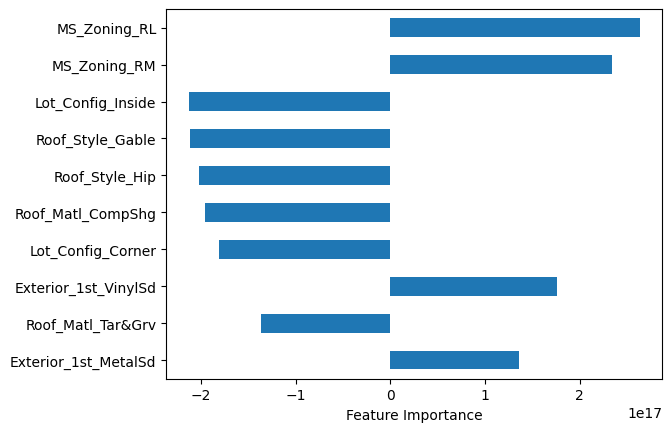

In [30]:

coefficents = model_lr.named_steps['linearregression'].coef_
features = model_lr.named_steps['onehotencoder'].get_feature_names_out()
feat_imp = pd.Series(coefficents, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Feature Importance');
